In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Tree / Boosting models
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [49]:
TRAIN_PATH = '/kaggle/input/mock-test-2-mse-2/train.csv'
TEST_PATH  = '/kaggle/input/mock-test-2-mse-2/test.csv'
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

In [50]:
train_df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,1481.0,Placebo,12963.0,F,N,Y,N,N,2.4,346.0,3.34,70.0,1212.0,122.45,118.0,117.0,12.2,4.0,C
1,1,2580.0,D-penicillamine,20819.0,F,N,N,N,N,0.6,NaN,4.52,51.0,645.0,74.40,NaN,181.0,10.4,3.0,C
2,2,837.0,D-penicillamine,12307.0,F,N,Y,Y,N,6.1,586.0,2.73,89.0,2045.0,196.85,90.0,228.0,10.4,3.0,D
3,3,3021.0,NaN,17532.0,F,NaN,NaN,NaN,N,0.6,NaN,3.34,NaN,NaN,NaN,NaN,388.0,10.4,3.0,C
4,4,1980.0,NaN,23011.0,F,NaN,NaN,NaN,N,0.8,NaN,3.65,NaN,NaN,NaN,NaN,190.0,11.1,4.0,C


In [51]:
TARGET_COL = 'Status' # Change to target col
ID_COL     = 'id'

In [ ]:
if train_df[TARGET_COL].isna().any():
    target_mode = train_df[TARGET_COL].mode(dropna=True)[0]
    train_df[TARGET_COL] = train_df[TARGET_COL].fillna(target_mode)

In [52]:
train_df.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,15000.000000,15000.00000,15000.000000,15000.000000,6625.000000,15000.000000,8343.000000,8453.000000,8449.000000,6578.000000,14418.000000,14981.000000,15000.000000
mean,7499.500000,1957.65580,19340.767667,1.869133,327.408755,3.523682,74.437732,1671.871596,106.072495,110.992703,253.589402,10.624471,3.037200
std,4330.271354,1346.32124,3731.980408,2.716933,172.503702,0.368956,72.604081,1874.328641,55.331238,50.127109,92.802002,0.728577,0.877497
min,0.000000,28.00000,1223.000000,0.300000,44.000000,1.960000,2.000000,140.000000,26.350000,4.000000,2.000000,9.000000,1.000000
25%,3749.750000,1095.00000,16714.000000,0.700000,242.000000,3.290000,31.000000,724.000000,71.000000,80.000000,183.000000,10.100000,2.000000
50%,7499.500000,1770.00000,19698.000000,0.900000,280.000000,3.580000,52.000000,1080.000000,97.650000,99.000000,249.000000,10.600000,3.000000
75%,11249.250000,2609.00000,22388.000000,1.800000,364.000000,3.770000,88.000000,1692.000000,130.200000,133.000000,311.000000,11.000000,4.000000
max,14999.000000,25569.00000,127321.000000,28.000000,2580.000000,4.640000,674.000000,20392.000000,2656.700000,598.000000,824.000000,18.000000,4.000000


In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8459 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8460 non-null   object 
 6   Hepatomegaly   8457 non-null   object 
 7   Spiders        8448 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6625 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8343 non-null   float64
 13  Alk_Phos       8453 non-null   float64
 14  SGOT           8449 non-null   float64
 15  Tryglicerides  6578 non-null   float64
 16  Platelets      14418 non-null  float64
 17  Prothrombin    14981 non-null  float64
 18  Stage 

In [ ]:

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df[TARGET_COL])

X = train_df.drop(columns=[c for c in [TARGET_COL, ID_COL] if c in train_df.columns])
test_ids = test_df[ID_COL].copy()
X_test = test_df.drop(columns=[ID_COL])

In [ ]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(exclude=['int64','float64']).columns

In [57]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [58]:
def cap_outliers(df, cols, lower=1, upper=99):
    """Caps outliers using percentile-based winsorization."""
    df = df.copy()
    for c in cols:
        lo, hi = df[c].quantile([lower/100, upper/100])
        df[c] = df[c].clip(lo, hi)
    return df

# Apply capping ONLY on feature matrices (never on target or id)
X = cap_outliers(X, num_cols)
X_test = cap_outliers(X_test, num_cols)

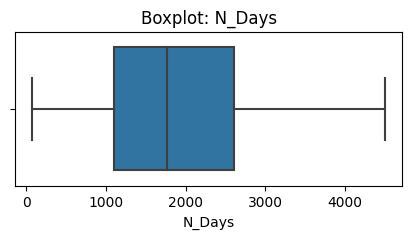

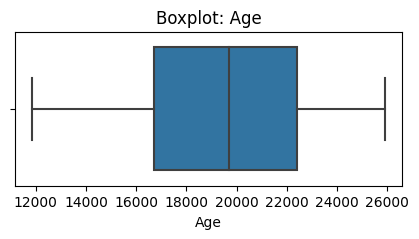

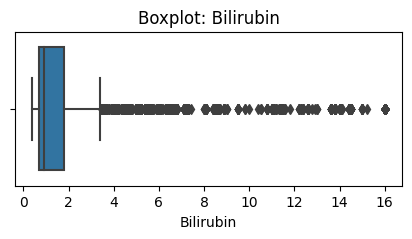

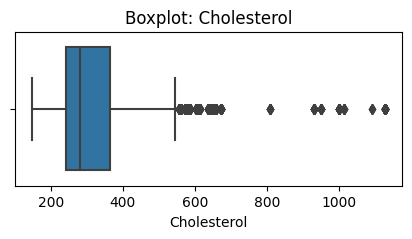

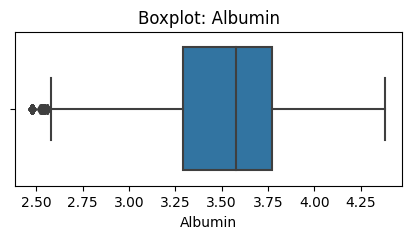

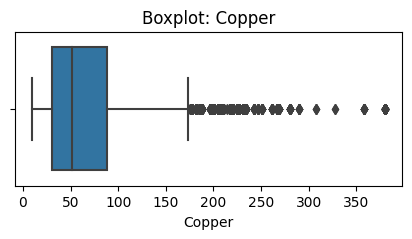

In [63]:
for col in num_cols[:6]:  # limit to avoid clutter
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot: {col}")
    plt.show()

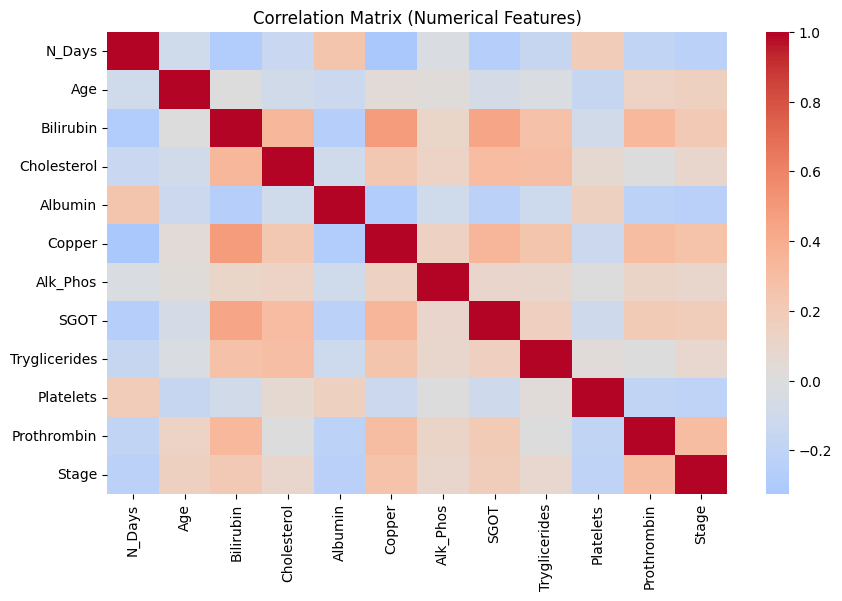

In [64]:
if len(num_cols) > 1:
    plt.figure(figsize=(10, 6))
    corr = X[num_cols].corr()
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title("Correlation Matrix (Numerical Features)")
    plt.show()

In [65]:
if len(num_cols) <= 5:
    sns.pairplot(train_df[num_cols.tolist() + [TARGET_COL]], hue=TARGET_COL)
    plt.show()

In [ ]:
models = {
    'RandomForest': RandomForestClassifier(
    n_estimators=500,
    criterion="log_loss",
    max_depth=8,
    min_samples_split=25,
    min_samples_leaf=15,
    max_features=0.7,
    class_weight="balanced",
    bootstrap=True,
    n_jobs=-1,
    random_state=42
),

    'LightGBM': lgb.LGBMClassifier(
    objective="multiclass",
    metric="multi_logloss",
    learning_rate=0.05,
    n_estimators=800,
    num_leaves=15,
    max_depth=5,

    min_child_samples=50,
    subsample=0.7,
    colsample_bytree=0.7,

    reg_alpha=1.5,
    reg_lambda=3.0,

    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    verbose = -1

),

    'XGBoost': xgb.XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",

    learning_rate=0.05,
    n_estimators=700,
    max_depth=4,

    min_child_weight=10,
    subsample=0.7,
    colsample_bytree=0.7,

    reg_alpha=1.5,
    reg_lambda=3.0,

    random_state=42,
    n_jobs=-1
)
}




In [67]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

from sklearn.base import clone

for name, model in models.items():
    losses = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        # IMPORTANT: clone model for each fold (fixes LightGBM/XGBoost feature mismatch)
        model_clone = clone(model)

        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model_clone)
        ])

        pipe.fit(X_tr, y_tr)
        val_pred = pipe.predict_proba(X_val)
        losses.append(log_loss(y_val, val_pred))

    results[name] = np.mean(losses)
    print(f"{name} CV LogLoss: {results[name]:.5f}")



RandomForest CV LogLoss: 0.39909
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 25
[LightGBM] [Info] Start training from score -0.394154
[LightGBM] [Info] Start training from score -3.698930
[LightGBM] [Info] Start training from score -1.200645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1894
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 25
[LightGBM] [Info] Start training from score -0.394154
[LightGBM] [Info] Start training from score -

In [ ]:
sorted_models = sorted(results.items(), key=lambda x: x[1])

best_model_name, best_score = sorted_models[0]
second_model_name, second_score = sorted_models[1]

best_model = models[best_model_name]
second_model = models[second_model_name]

print(f"Top-2 Models Selected:")
print(f"{best_model_name} (LogLoss: {best_score:.5f})")
print(f"{second_model_name} (LogLoss: {second_score:.5f})")


Best Model Selected: XGBoost


In [ ]:
USE_CALIBRATION_FOR_LOGLOSS = True  # keep True for log-loss competitions

from sklearn.calibration import CalibratedClassifierCV

pipelines = {}

for name, model in [(best_model_name, best_model), (second_model_name, second_model)]:
    if USE_CALIBRATION_FOR_LOGLOSS:
        calibrated_model = CalibratedClassifierCV(
            estimator=model,
            method='isotonic',
            cv=3
        )
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', calibrated_model)
        ])
    else:
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
    pipe.fit(X, y)
    pipelines[name] = pipe


In [ ]:
SUBMIT_PROBABILITIES = True   # True → log_loss submission
SUBMIT_LABELS        = False  # True → accuracy / precision submission

In [ ]:
W1, W2 = 0.65, 0.35

proba_1 = pipelines[best_model_name].predict_proba(X_test)
proba_2 = pipelines[second_model_name].predict_proba(X_test)

y_pred_prob = W1 * proba_1 + W2 * proba_2
y_pred_labels_enc= pipelines[best_model_name].predict(X_test)

In [ ]:
if SUBMIT_PROBABILITIES:

    n_classes = y_pred_prob.shape[1]
    encoded_classes = np.arange(n_classes)

    original_labels = label_encoder.inverse_transform(encoded_classes)


    #match with sample submission

    submission_cols = [f"Status_{cls}" for cls in original_labels]
    # submission_cols = [f"{cls}" for cls in original_labels]
    # submission_cols = [f"{TARGET_COL}_{cls}" for cls in original_labels]

    submission = pd.DataFrame(y_pred_prob, columns=submission_cols)
    submission.insert(0, ID_COL, test_ids if test_ids is not None else range(len(submission)))

    # ---- To REORDER EXACTLY LIKE sample_submission.csv IF AVAILABLE ----

    # try:
    #     sample_sub = pd.read_csv('sample_submission.csv')
    #     ordered_cols = sample_sub.columns.tolist()
    #     submission = submission[ordered_cols]
    #     print('Reordered columns using sample_submission.csv')
    # except Exception:
    #     print('sample_submission.csv not found – using inverse-transformed class order')

    submission.to_csv('Submission.csv', index=False)
    print('Submission.csv generated (probabilities)')
    print(submission.head())



sample_submission.csv not found – using inverse-transformed class order
Submission.csv generated (probabilities)
      id  Status_C  Status_CL  Status_D
0  15000  0.983713   0.000606  0.015681
1  15001  0.965211   0.001545  0.033244
2  15002  0.897917   0.010128  0.091955
3  15003  0.136880   0.019807  0.843313
4  15004  0.989290   0.000603  0.010107


In [ ]:
if SUBMIT_LABELS:
    # • For accuracy / precision → use model.predict()

    y_pred_labels = label_encoder.inverse_transform(y_pred_labels_enc)

    labels_df = pd.DataFrame({
        ID_COL: test_df[ID_COL],
        f'{TARGET_COL}': y_pred_labels
    })

    labels_df.to_csv('Submission_labels.csv', index=False)
    print('Submission_labels.csv generated (labels)')